In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# !ls sst2

data  README.md


In [ ]:
# !pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00


In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig, AutoModel, get_cosine_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from tqdm.auto import tqdm

# 固定seed
torch.manual_seed(42)
# 确定设备：如果有GPU可用则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#如果GPU可以，可以改为20
# num_epochs = 10
# patience = 5

training_record = {}

cuda


## preparation

SST-2（Stanford Sentiment Treebank）是斯坦福大学发布的一个用于情感分析的数据集，旨在对句子的情感进行分类。该数据集中包含电影评论句子，每个句子都带有相应的情感标签。情感标签分为两类：正面（positive）和负面（negative），因此 SST-2 是一个二分类任务的数据集。

Positive（正面）：

"The movie was absolutely fantastic."（这部电影绝对太棒了。）
"I loved the acting and the storyline."（我喜欢演技和故事情节。）

Negative（负面）：

"The film was a complete disaster."（这部电影完全是个灾难。）
"The acting was terrible, I wouldn't recommend it."（演技糟糕，我不推荐这部电影。）

### load dataset

In [2]:
# dataset
dataset_sst2 = load_dataset(
    "parquet",
    data_files={
        "train": "./sst2/data/train-00000-of-00001.parquet",
        "validation": "./sst2/data/validation-00000-of-00001.parquet"
        })

# load_dataset: 这是 datasets 库中的一个函数，用于加载数据集。
# "parquet": 指定了数据集的格式，这里是 Parquet 格式，一种列存储的文件格式，常用于存储大型数据集。
# data_files: 一个字典，指定了训练集和验证集的文件路径。每个键值对中的键是数据集的名称（如 "train" 和 "validation"），值是对应的 Parquet 文件的路径。

In [3]:
print(type(dataset_sst2))

<class 'datasets.dataset_dict.DatasetDict'>


In [4]:
print(dataset_sst2["train"])

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 67349
})


In [3]:
# tokenizer
tokenizer = AutoTokenizer.from_pretrained("./bert-base-uncased")

# preprocessing
def collate_fn(batch):
    inputs = tokenizer([x["sentence"] for x in batch], padding="longest", truncation=True, return_tensors="pt", max_length=512)
    labels = torch.tensor([x["label"] for x in batch])
    return inputs, labels

train_loader = DataLoader(dataset_sst2["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset_sst2["validation"], batch_size=32, collate_fn=collate_fn)

In [8]:
# 遍历 DataLoader 中的一个批次示例
for inputs, labels in train_loader:
    print(inputs)
    print(inputs['input_ids'].shape)
    print(labels)
    break
     
# {'input_ids': tensor([[ 101, 2019, 2035,  ...,    0,    0,    0],
#         [ 101, 4165, 1010,  ...,    0,    0,    0],
#         [ 101, 2006, 2019,  ...,    0,    0,    0],
#         ...,
#         [ 101, 1037, 2107,  ...,    0,    0,    0],
#         [ 101, 2003, 2524,  ...,    0,    0,    0],
#         [ 101, 2107, 2019,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
#         [0, 0, 0,  ..., 0, 0, 0],
#         [0, 0, 0,  ..., 0, 0, 0],
#         ...,
#         [0, 0, 0,  ..., 0, 0, 0],
#         [0, 0, 0,  ..., 0, 0, 0],
#         [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
#         [1, 1, 1,  ..., 0, 0, 0],
#         [1, 1, 1,  ..., 0, 0, 0],
#         ...,
#         [1, 1, 1,  ..., 0, 0, 0],
#         [1, 1, 1,  ..., 0, 0, 0],
#         [1, 1, 1,  ..., 0, 0, 0]])}
# tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
#         1, 0, 1, 0, 1, 0, 1, 0])

{'input_ids': tensor([[  101,  5695, 17188,  ...,     0,     0,     0],
        [  101,  1037, 10520,  ...,     0,     0,     0],
        [  101, 19907,  1997,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  2143,  ...,     0,     0,     0],
        [  101,  1996,  3291,  ...,     0,     0,     0],
        [  101,  6970, 13068,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
torch.Size([32, 43])
tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0])


### define evaluattion and training function

In [4]:
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():# 在评估过程中关闭梯度计算
        total_samples = 0
        for inputs, labels in val_loader:
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            probs = model(**inputs)
            loss = F.binary_cross_entropy(probs, labels.float())
            val_loss += loss.item()
            val_acc += ((probs > 0.5) == labels).sum().item() #模型的预测结果与实际标签是否相等,求和得到预测正确数量
            total_samples += len(labels)

    val_loss /= len(val_loader)
    val_acc /= total_samples
    return val_loss, val_acc


def train(model, train_loader, val_loader, device, num_epochs=10, patience=3):
    # 将模型移动到指定设备
    model.to(device)

    # 定义优化器
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    # 计算训练总步数
    total_steps = num_epochs * len(train_loader)

    # 使用transformers库中的余弦学习率调度器进行学习率调整
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.2 * total_steps),
        num_training_steps=total_steps
    )

    # 提前停止训练的控制变量
    best_val_acc = -1
    cur = 0

    # 存储训练和验证指标的容器
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # 进入训练模式
        model.train()
        train_loss = 0
        train_acc = 0
        total_samples = 0

        # 对训练数据进行迭代
        for inputs, labels in tqdm(train_loader):
            # 将数据移动到指定设备
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            # 前向传播并计算损失
            optimizer.zero_grad()
            probs = model(**inputs)
            loss = F.binary_cross_entropy(probs, labels.float())
            loss.backward()
            optimizer.step()
            scheduler.step()

            # 收集指标
            train_loss += loss.item()
            train_acc += ((probs > 0.5) == labels).sum().item()
            total_samples += len(labels)

        train_loss /= len(train_loader)
        train_acc  /= total_samples

        # 进行验证
        val_loss, val_acc = evaluate(model, val_loader)

        # 记录指标
        print(f"epoch {epoch}: train_loss {train_loss:.4f}, train_acc {train_acc:.4f}, val_loss {val_loss:.4f}, val_acc {val_acc:.4f}")
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # 提前停止训练
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            cur = 0
        else:
            cur += 1
        if cur >= patience:
            print("提前停止训练")
            break

    return history

### a function to check the parameters that could be fintuned

In [5]:
def human_readable_count(n):
    # 定义一个函数，用于处理可读性较好的数字格式
    if n < 1_000:
        return f"{n}"
    elif n < 1_000_000:
        return f"{n/1_000:.2f}K"  # 如果在千到百万之间，使用K表示
    elif n < 1_000_000_000:
        return f"{n/1_000_000:.2f}M"  # 如果在百万到十亿之间，使用M表示
    else:
        return f"{n/1_000_000_000:.2f}B"  # 如果大于十亿，使用B表示


def count_parameters(model):
    # 统计模型参数
    total_params = sum(p.numel() for p in model.parameters())  # 总参数数量
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 可训练参数数量
    frozen_params = total_params - trainable_params  # 冻结参数数量

    # 输出参数数量
    print(f"Total Parameters:\t{human_readable_count(total_params):>8}")  # 输出总参数数量（格式化为可读性更好的格式）
    print(f"Frozen Parameters:\t{human_readable_count(frozen_params):>8}")  # 输出冻结参数数量（格式化为可读性更好的格式）
    print(f"Trainable Parameters:\t{human_readable_count(trainable_params):>8}\t{trainable_params / total_params:.2%}")  # 输出可训练参数数量以及所占比例

In [6]:
import matplotlib.pyplot as plt  # 导入绘图库

def plot_training_record(training_record, metric_name="val_acc"):
    """
    绘制训练记录图表

    参数:
    training_record(dict): 包含训练记录的字典，键为方法名称，值为记录的字典
    metric_name(str): 要绘制的度量名称，默认为"val_acc"（验证准确度）

    返回:
    无（直接展示图表）
    """
    plt.figure(figsize=(12, 6))  # 设置图表大小
    for method_name, record in training_record.items():  # 遍历每个方法的记录
        metrics = record[metric_name]  # 获取指定度量的数值
        plt.plot(range(len(metrics)), metrics, label=method_name)  # 绘制曲线

    plt.xlabel("Epoch")  # 设置X轴标签
    plt.ylabel("Validation Accuracy")  # 设置Y轴标签
    plt.legend()  # 显示图例
    plt.grid()  # 显示网格线
    plt.show()  # 展示图表

## A Frozen pretrained Bert as a feature extractor  将预训练过的Bert冻结作为特征提取器

In [18]:
# 定义一个继承自 nn.Module 的 FrozenBert 类
class FrozenBert(nn.Module):
    def __init__(self):
      super().__init__()
      # 加载预训练的BERT模型
      self.model = AutoModel.from_pretrained("./bert-base-uncased")

      # 添加一个线性分类器，其输入尺寸是BERT模型的隐藏层尺寸，输出是1
      self.classifier = nn.Linear(self.model.config.hidden_size, 1)

      # 冻结BERT模型的所有参数，这样在训练过程中它们不会被更新
      for param in self.model.parameters():
          param.requires_grad = False

    # 定义前向传播过程
    def forward(self, **inputs):
      # 获取BERT的最后一个隐藏层的输出，并选中序列的第一项（[CLS] token）
      # last_hidden_state（tf.Tensor形状(batch_size, sequence_length, hidden_size)）—模型最后一层输出的隐藏状态序列。
      feature = self.model(**inputs).last_hidden_state[:, 0, :]
      # 将特征通过线性分类器获取对数几率
      logits = self.classifier(feature)
      # 应用sigmoid激活函数并将结果集中成一维输出
      return torch.sigmoid(logits).squeeze()


# 实例化FrozenBert类，创建一个模型对象
frozen_bert = FrozenBert()
print(frozen_bert)
# 定义一个函数（此函数未在代码中提供），用来计算模型的参数数量
count_parameters(frozen_bert)

# training_record一个训练记录字典，来记录不同训练阶段的信息，在最上面进行的初始化

# 调用train函数来训练模型，传递模型对象、训练数据加载器、验证数据加载器、
# 使用设备、训练迭代次数和早停耐心值（这些变量在代码中没有定义）
training_record["Frozen"] = train(frozen_bert, train_loader, val_loader, device, num_epochs=6, patience=4)

FrozenBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.7045, train_acc 0.5576, val_loss 0.6859, val_acc 0.5229


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.6591, train_acc 0.5975, val_loss 0.6319, val_acc 0.6594


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.6241, train_acc 0.6672, val_loss 0.5958, val_acc 0.7718


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.6022, train_acc 0.7153, val_loss 0.5766, val_acc 0.7890


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.5903, train_acc 0.7334, val_loss 0.5682, val_acc 0.7924


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 5: train_loss 0.5874, train_acc 0.7400, val_loss 0.5670, val_acc 0.7913


In [19]:
training_record["Frozen"]

{'train_loss': [0.7045348924582474,
  0.659125609126057,
  0.6241035917309288,
  0.6021528547563348,
  0.5902865215038744,
  0.5873512595821163],
 'train_acc': [0.5575583898795825,
  0.597484743648755,
  0.6671517023266864,
  0.7152593208510891,
  0.7334036140106015,
  0.74004068360332],
 'val_loss': [0.6859368873494012,
  0.6318849942513874,
  0.5958419506038938,
  0.5766055881977081,
  0.5682416962725776,
  0.5670408723609788],
 'val_acc': [0.5229357798165137,
  0.6594036697247706,
  0.7717889908256881,
  0.7889908256880734,
  0.7924311926605505,
  0.7912844036697247]}

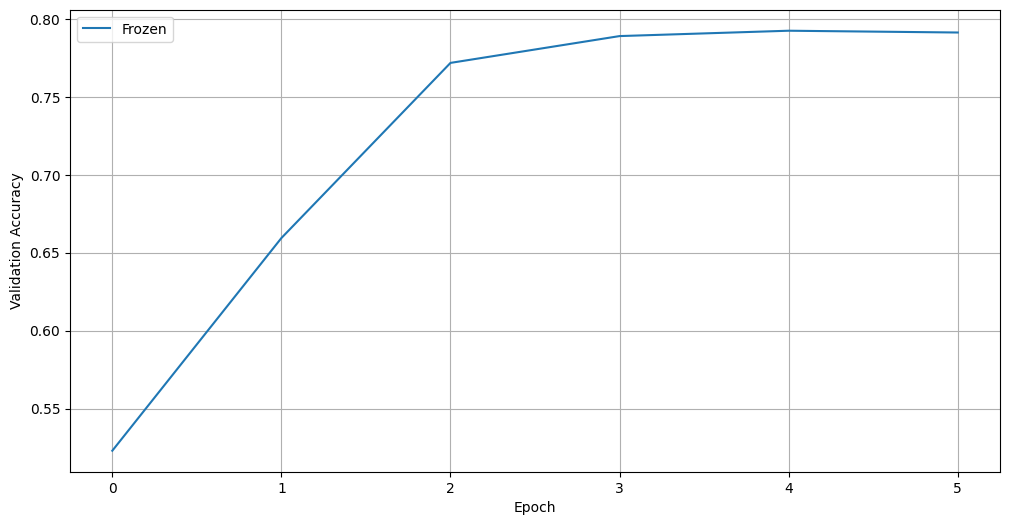

In [20]:
plot_training_record(training_record, metric_name="val_acc")

## Fully Finetuning

In [21]:
class FullyFinetunedBert(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = AutoModel.from_pretrained("./bert-base-uncased")  # 从预训练模型加载BERT
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)  # 添加线性分类器，输出维度为1

    def forward(self, **inputs):
        feature = self.model(**inputs).last_hidden_state[:, 0, :]  # 获取特征向量
        logits = self.classifier(feature)  # 应用分类器
        return torch.sigmoid(logits).squeeze()  # 使用sigmoid激活函数并压缩维度


# 加载预训练模型
fully_fine_tuned_bert = FullyFinetunedBert()
print('-'*50)
print(fully_fine_tuned_bert)
print('-'*50)
# 检查参数数量
count_parameters(fully_fine_tuned_bert)

--------------------------------------------------
FullyFinetunedBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              

In [ ]:
# 训练(全量，拿到colab试试)
training_record["Fully Fine-Tuning"] = train(
    fully_fine_tuned_bert,
    train_loader,
    val_loader,
    device,
    num_epochs=num_epochs,
    patience=patience
    )  # 对完全微调的BERT进行训练，并将训练记录保存在training_record中

In [22]:
del fully_fine_tuned_bert

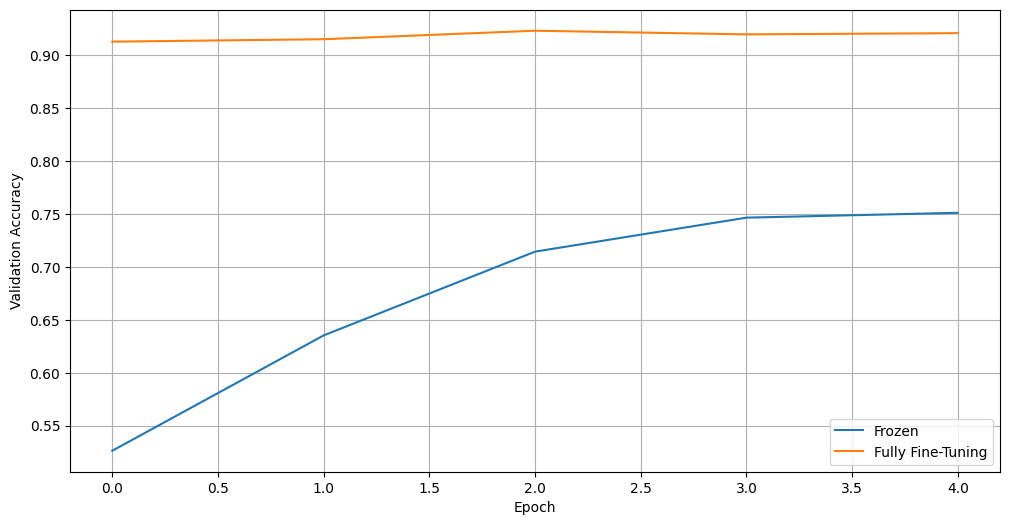

In [ ]:
#可以看到全量微调的效果非常好
plot_training_record(training_record, metric_name="val_acc")

## BitFit

BitFit（论文：BitFit: Simple Parameter-efficient Fine-tuning or Transformer-based Masked Language-models）是一种稀疏的微调方法，它训练时只更新bias的参数或者部分bias参数。

In [23]:
class BitFitBert(nn.Module):
    def __init__(self):
        super().__init__()
        # 加载预训练模型
        self.model = AutoModel.from_pretrained("./bert-base-uncased")
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 冻结除所有偏置项之外的参数
        for name, param in self.model.named_parameters():
            if "bias" not in name:
                param.requires_grad = False

    def forward(self, **inputs):
        feature = self.model(**inputs).last_hidden_state[:, 0, :]  # 获取特征向量
        logits = self.classifier(feature)  # 应用分类器
        return torch.sigmoid(logits).squeeze()  # 使用sigmoid激活函数并压缩维度


# 加载预训练模型
bitfit_bert = BitFitBert()
print('-'*50)
print(bitfit_bert)
print('-'*50)
# 检查参数数量
count_parameters(bitfit_bert)

--------------------------------------------------
BitFitBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

In [24]:
# 训练
training_record["BitFit"] = train(bitfit_bert, train_loader, val_loader, device, num_epochs=6, patience=4)  # 对BitFitBert进行训练，并将训练记录保存在training_record中

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6864, train_acc 0.5449, val_loss 0.6647, val_acc 0.6101


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.4897, train_acc 0.7857, val_loss 0.3589, val_acc 0.8509


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.3402, train_acc 0.8592, val_loss 0.3344, val_acc 0.8681


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.3249, train_acc 0.8658, val_loss 0.3238, val_acc 0.8693


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.3186, train_acc 0.8663, val_loss 0.3208, val_acc 0.8704


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 5: train_loss 0.3175, train_acc 0.8680, val_loss 0.3208, val_acc 0.8716


In [ ]:
del bitfit_bert

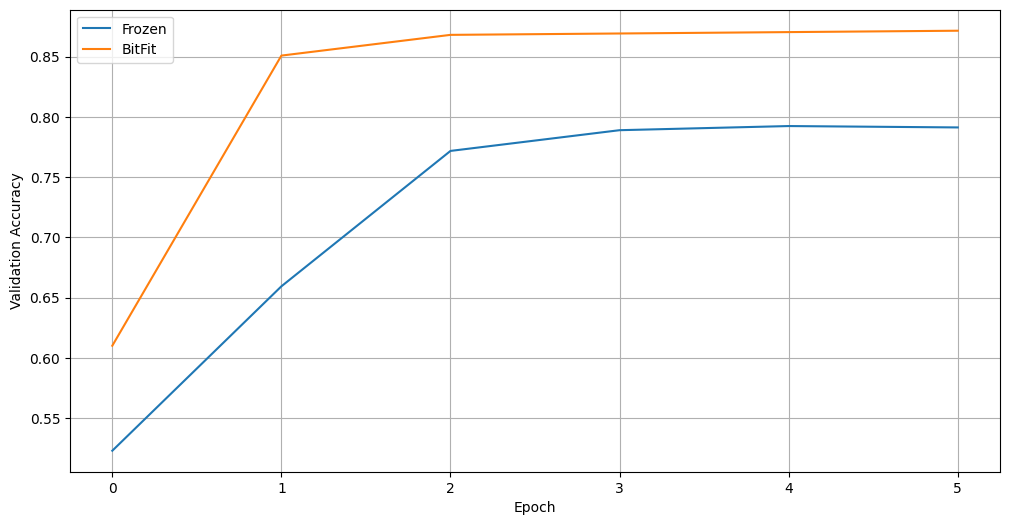

In [25]:
#偏置项冻结后效果变差了一些
plot_training_record(training_record, metric_name="val_acc")

## P-Tuning & P-Tuning v2 & Prefix Tuning

Prefix Tuning（论文：Prefix-Tuning: Optimizing Continuous Prompts for Generation），在输入token之前构造一段任务相关的virtual tokens作为Prefix，然后训练的时候只更新Prefix部分的参数，而PLM中的其他部分参数固定。

* 针对不同的模型结构，需要构造不同的Prefix。
    * 针对自回归架构模型：在句子前面添加前缀，得到 z = [PREFIX; x; y]，合适的上文能够在固定 LM 的情况下去引导生成下文（比如：GPT3的上下文学习）。
    * 针对编码器-解码器架构模型：Encoder和Decoder都增加了前缀，得到 z = [PREFIX; x; PREFIX0; y]。Encoder端增加前缀是为了引导输入部分的编码，Decoder 端增加前缀是为了引导后续token的生成。


P-Tuning（论文：GPT Understands, Too），该方法将Prompt转换为可以学习的Embedding层，并用MLP+LSTM的方式来对Prompt Embedding进行一层处理。

相比Prefix Tuning，P-Tuning加入的可微的virtual token，但仅限于输入层，没有在每一层都加；另外，virtual token的位置也不一定是前缀，插入的位置是可选的。这里的出发点实际是把传统人工设计模版中的真实token替换成可微的virtual token。

P-Tuning v2（论文： P-Tuning v2: Prompt Tuning Can Be Comparable to Fine-tuning Universally Across Scales and Tasks），该方法在每一层都加入了Prompts tokens作为输入，而不是仅仅加在输入层，这带来两个方面的好处：

更多可学习的参数（从P-tuning和Prompt Tuning的0.01%增加到0.1%-3%），同时也足够参数高效。
加入到更深层结构中的Prompt能给模型预测带来更直接的影响。


自然语言生成 (NLG) 和 自然语言理解 (NLU)
### 区别

|方法|参数重整化| 微调参数所在层 | 适配下游任务 |
|-|-|-|-|
|P-tuning|MLP + LSTM 或者 MLP| embedding 层| 使得GPT做NLU |
|P-tuning v2|不使用| 每一层 | NLG & NLU |
|prefix tuning|MLP| 每一层 | NLG |

In [7]:
import torch
import torch.nn as nn
from transformers import AutoModel
import torch.nn.functional as F
import numpy as np

class PTuningBert(nn.Module):
    def __init__(self, num_virtual_tokens=20, reparameterization_type="MLP"):
        super().__init__()
        # 加载预训练模型
        self.model = AutoModel.from_pretrained("./bert-base-uncased")
        self.classifier = nn.Linear(self.model.config.hidden_size, 1) # （768，1）

        # 冻结除分类器层之外的参数
        for param in self.model.parameters():
            param.requires_grad = False

        hidden_size = self.model.config.hidden_size
        self.num_virtual_tokens = num_virtual_tokens
        # 定义一个可学习的参数，作为虚拟提示的初始值，其形状为(num_virtual_tokens, hidden_size)
        self.prompt = nn.Parameter(torch.zeros(self.num_virtual_tokens, hidden_size))

        # 重新参数化,根据传入的reparameterization_type参数，初始化不同的重新参数化头部
        self.reparameterization_type = reparameterization_type
        if reparameterization_type == "MLP":
            self.mlp_head = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
            )
        elif reparameterization_type == "LSTM":
            self.lstm_head = nn.LSTM(
                input_size=hidden_size,
                hidden_size=hidden_size,
                num_layers=2,
                bidirectional=True,
                batch_first=True,
            )
            self.mlp_head = nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size * 2),
                nn.ReLU(),
                nn.Linear(hidden_size * 2, hidden_size),
            )

    def forward(self, input_ids, attention_mask, **args):  # input_ids:(32，43)
        # 获取输入的批次大小
        batch_size = input_ids.size(0)
        # 将虚拟提示扩展到与输入相同批次大小
        prompt = self.prompt.unsqueeze(0).expand(batch_size, -1, -1)
        # print(prompt.shape) # 32，20，768
        # 根据选择的重新参数化类型，对虚拟提示进行处理
        if self.reparameterization_type == "MLP":
            prompt = self.mlp_head(prompt)
        elif self.reparameterization_type == "LSTM":
            prompt, _ = self.lstm_head(prompt)
            # print(prompt.shape) # 32，20，768*2
            prompt = self.mlp_head(prompt) # 32，20，768

        # 将虚拟提示与输入的嵌入层输出连接，形成扩展的输入嵌入
        embedding_output = self.model.embeddings(input_ids)
        # print(embedding_output.shape) # (32，43) > (32，43，768)
        extended_inputs_embeds = torch.cat([prompt, embedding_output], dim=1)
        # 32,63,768
        extended_attention_mask = torch.cat([
            torch.ones(batch_size, self.num_virtual_tokens).to(input_ids.device),
            attention_mask
        ], dim=1)
        # 32,63

        #将扩展的输入嵌入和注意力掩码输入BERT模型
        outputs = self.model(inputs_embeds=extended_inputs_embeds, attention_mask=extended_attention_mask)
        # outputs.last_hidden_state:32,63,768
        # 获取经过BERT模型处理后的特定位置的特征，即虚拟提示之后的第一个位置
        feature = outputs.last_hidden_state[:, self.num_virtual_tokens, :]
        # print(feature.shape) # 32,768
        logits = self.classifier(feature)
        return torch.sigmoid(logits).squeeze()


# 加载预训练模型
ptuning_bert = PTuningBert()
print('-'*50)
print(ptuning_bert)
print('-'*50)
# 记录参数数量
count_parameters(ptuning_bert)

--------------------------------------------------
PTuningBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [8]:
# test_input_ids = torch.randint(1, 100, size=(32, 512))
# test_attention_mask = torch.ones(32,512)
# 
# test_ptuning_bert = PTuningBert(num_virtual_tokens=20, reparameterization_type="LSTM")
# test_ptuning_bert(test_input_ids, test_attention_mask)

torch.Size([32, 20, 768])
torch.Size([32, 20, 1536])
torch.Size([32, 512, 768])


RuntimeError: The expanded size of the tensor (532) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [32, 532].  Tensor sizes: [1, 512]

In [9]:
# 进行训练
training_record["P-Tuning"] = train(ptuning_bert, train_loader, val_loader, device, num_epochs=6, patience=4)

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6782, train_acc 0.5544, val_loss 0.6268, val_acc 0.6766


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.5717, train_acc 0.7074, val_loss 0.5343, val_acc 0.7362


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.5200, train_acc 0.7458, val_loss 0.4979, val_acc 0.7546


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.4959, train_acc 0.7602, val_loss 0.4852, val_acc 0.7592


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.4875, train_acc 0.7667, val_loss 0.4891, val_acc 0.7443


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 5: train_loss 0.4829, train_acc 0.7714, val_loss 0.4814, val_acc 0.7626


In [11]:
del ptuning_bert

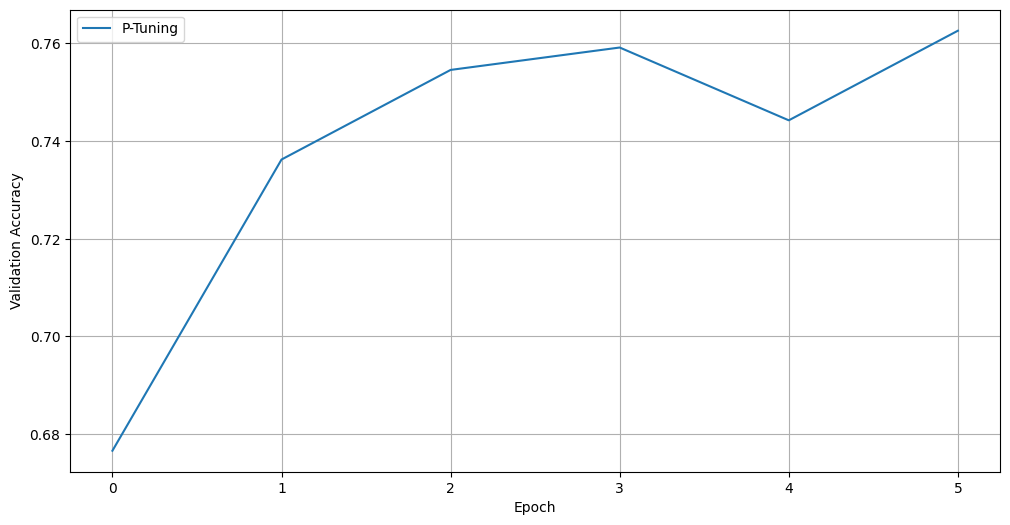

In [10]:
plot_training_record(training_record, metric_name="val_acc")

In [7]:
# 定义一个继承自nn.Module的类，用于前缀调优的BERT模型
class PrefixTuningBert(nn.Module):
    def __init__(self, num_virtual_tokens=20, prefix_projection=True):
        super().__init__()  # 调用父类的初始化方法
        # 加载预训练的BERT模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        # 添加一个线性分类层
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 冻结预训练模型的参数，只训练分类器层
        for param in self.model.parameters():
            param.requires_grad = False

        # 前缀相关的参数
        self.num_virtual_tokens = num_virtual_tokens  # 虚拟token的数量
        self.prefix_projection = prefix_projection  # 是否使用前缀投影
        hidden_size = self.model.config.hidden_size  # 隐藏层大小
        self.num_layers = self.model.config.num_hidden_layers  # Transformer层数
        self.num_attention_heads = self.model.config.num_attention_heads  # 注意力头数
        self.embed_size_per_head = hidden_size // self.num_attention_heads  # 每个头的嵌入大小 head_dim

        # 如果使用前缀投影
        if self.prefix_projection:
            # 使用两层MLP来编码前缀token
            self.prefix_tokens = nn.Parameter(torch.zeros(self.num_virtual_tokens, hidden_size))
            self.transform = torch.nn.Sequential(
                torch.nn.Linear(hidden_size, hidden_size),  # 第一层MLP
                torch.nn.Tanh(),  # 使用tanh激活函数
                torch.nn.Linear(hidden_size, self.num_layers * 2 * hidden_size),  # 第二层MLP
            )
        else:
            # 不使用前缀投影，直接使用token
            self.prefix_tokens = nn.Parameter(torch.zeros(self.num_virtual_tokens, hidden_size))

    def forward(self, input_ids, attention_mask, **args): # # input_ids:(32，43)
        # 将前缀token投影并分割为key和value
        batch_size = input_ids.size(0) #获得批次大小
        prefix_tokens = self.prefix_tokens.unsqueeze(0).expand(batch_size, -1, -1)
        # print(prefix_tokens.shape)
        if self.prefix_projection:
            past_key_values = self.transform(prefix_tokens)
            # print(past_key_values.shape) # (32,20,2*12*768) 
        else:
            past_key_values = prefix_tokens

        # 改变形状以适配Transformer的输入格式
        past_key_values = past_key_values.view(batch_size, self.num_layers, 2, self.num_attention_heads, -1, self.embed_size_per_head) # (32, 12 ,2 ,12, 20, 64)
        # print(past_key_values.shape)
        # 重新排列维度以适配Transformer的输入格式
        past_key_values = past_key_values.permute(2, 1, 0, 3, 4, 5) # (2, 12, 32, 12, 20, 64)
        # 分离成多个包含key和value的元组，每个元组对应一层Transformer
        past_key_values = tuple([tuple([past_key_values[0][i], past_key_values[1][i]]) for i in range(self.num_layers)])
        # 一共12个encoder块，每个块中 分头后得到keys,values 加上(32, 12, 20, 64) 
        # keys,values:(32,12,63,64)

        # 修改注意力掩码，包含前缀token
        extended_attention_mask = torch.cat([
            torch.ones(batch_size, self.num_virtual_tokens).to(attention_mask.device),  # 前缀的注意力掩码
            attention_mask
            ], dim=1)
        # print(f'extended_attention_mask的shape:{extended_attention_mask.shape}') # 32,63
        # 将数据输入到BERT模型中
        outputs = self.model(input_ids, extended_attention_mask, past_key_values=past_key_values)
        # print(outputs.last_hidden_state.shape)
        # outputs.last_hidden_state:(32,43,768)
        feature = outputs.last_hidden_state[:, 0, :]  # 获取[CLS] token的特征表示

        # 使用分类层进行分类
        logits = self.classifier(feature)

        # 返回sigmoid激活后的logits
        return torch.sigmoid(logits).squeeze()

# 创建前缀调优BERT模型实例
prefix_tuning_bert = PrefixTuningBert()
print(prefix_tuning_bert)
# 计算模型参数数量
count_parameters(prefix_tuning_bert)

PrefixTuningBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [17]:
test_input_ids = torch.randint(1, 100, size=(32, 43))
test_attention_mask = torch.ones(32,43)

prefix_tuning_bert(test_input_ids, test_attention_mask)

torch.Size([32, 20, 768])
torch.Size([32, 20, 18432])
torch.Size([32, 20, 768])
extended_attention_mask的shape:torch.Size([32, 63])
torch.Size([32, 43, 768])


tensor([0.3795, 0.3898, 0.3860, 0.3890, 0.3775, 0.3772, 0.3788, 0.3815, 0.3845,
        0.3668, 0.3815, 0.3916, 0.3841, 0.3853, 0.3792, 0.3768, 0.3812, 0.3841,
        0.3790, 0.3846, 0.3793, 0.3710, 0.3821, 0.3883, 0.3764, 0.3813, 0.3872,
        0.3828, 0.3848, 0.3851, 0.3873, 0.3794], grad_fn=<SqueezeBackward0>)

In [8]:
# 训练模型，这里的train函数和train_loader、val_loader等变量需要在其他地方定义
# num_epochs和patience变量也需要在其他地方定义
training_record["Prefix Tuning"] = train(prefix_tuning_bert, train_loader, val_loader, device, num_epochs=6, patience=4)

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6948, train_acc 0.5133, val_loss 0.6788, val_acc 0.5287


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.4204, train_acc 0.8000, val_loss 0.3145, val_acc 0.8647


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.3096, train_acc 0.8709, val_loss 0.2994, val_acc 0.8635


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.2955, train_acc 0.8775, val_loss 0.2851, val_acc 0.8796


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.2864, train_acc 0.8800, val_loss 0.2819, val_acc 0.8796


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 5: train_loss 0.2834, train_acc 0.8820, val_loss 0.2810, val_acc 0.8796


In [ ]:
del prefix_tuning_bert

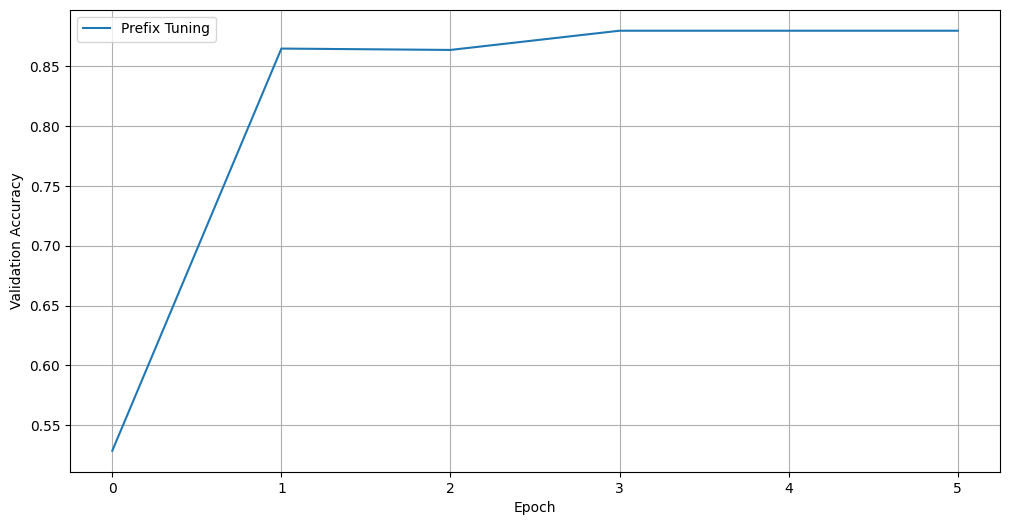

In [9]:
plot_training_record(training_record, metric_name="val_acc")

## LoRA

LoRA（论文：LoRA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS），该方法的核心思想就是通过低秩分解来模拟参数的改变量，从而以极小的参数量来实现大模型的间接训练。

在涉及到矩阵相乘的模块，在原始的PLM旁边增加一个新的通路，通过前后两个矩阵A,B相乘，第一个矩阵A负责降维，第二个矩阵B负责升维，中间层维度为r，从而来模拟所谓的本征秩（intrinsic rank）。

rank的作用：
rank代表低秩矩阵的秩，即线性变换矩阵A和B的输出特征数量。在LoRA中，原始的高维特征通过线性变换A被映射到一个低维空间（rank维），然后再通过另一个线性变换B映射回原始特征空间。较低的rank值意味着更少的参数需要更新，从而降低了模型复杂度和计算成本。

lora_alpha的作用：
lora_alpha是一个缩放因子，用于调整LoRA输出的贡献。它通过除以rank来计算得到scaling，这个缩放因子被用于控制低秩空间中的特征对最终输出的贡献度。较大的lora_alpha值会增加LoRA特征的影响力，而较小的值则会减少其影响。

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

# 定义LoRALayer类，它继承自PyTorch的nn.Module
class LoRALayer(nn.Module):
    def __init__(self, module: nn.Module, rank: int = 1, lora_alpha: int = 1):
        super().__init__()
        # 确保输入的rank是正整数
        assert isinstance(rank, int) and rank > 1, "Lora rank should be a positive integer"

        # 计算缩放因子
        self.scaling = lora_alpha / rank
        # 存储传入的模块
        self.module = module
        # 定义从输入特征到rank维空间的线性变换A
        self.A = nn.Linear(module.in_features, rank, bias=False)
        # 定义从rank维空间到输出特征的线性变换B
        self.B = nn.Linear(rank, module.out_features, bias=False)
        # 使用Kaiming均匀初始化方法初始化A的权重
        nn.init.kaiming_uniform_(self.A.weight, a=5 ** 0.5)
        # 将B的权重初始化为0
        nn.init.zeros_(self.B.weight)
        # 将A和B移动到与模块权重相同的设备上
        self.A.to(device=module.weight.device)
        self.B.to(device=module.weight.device)

    # 前向传播函数
    def forward(self, inputs, *args, **kwargs):
        # 首先通过原始模块进行前向传播
        with torch.no_grad():  # 确保这个操作不会影响梯度计算
            outputs = self.module(inputs, *args, **kwargs)
        # 计算LoRA的输出并加到原始模块的输出上
        return outputs + self.B(self.A(inputs)) * self.scaling

# 定义LoRABert类，它也继承自PyTorch的nn.Module
class LoRABert(nn.Module):
    # 初始化函数
    def __init__(self, rank=8, lora_alpha=32):
        # 调用父类的初始化函数
        super().__init__()
        # 加载预训练的BERT模型
        self.model = AutoModel.from_pretrained("./bert-base-uncased")
        # 应用LoRA技术到BERT模型的查询投影和键投影
        self._apply_lora(rank=rank, lora_alpha=lora_alpha)
        # 定义一个线性分类器，用于最后的任务分类
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

    # 应用LoRA到BERT模型的辅助函数
    def _apply_lora(self, rank, lora_alpha):
        # 冻结预训练模型的参数
        for param in self.model.parameters():
            param.requires_grad = False
        # 对BERT模型中的每一层应用LoRA
        for layer in self.model.encoder.layer.children():
            layer.attention.self.query = LoRALayer(layer.attention.self.query, rank=rank, lora_alpha=lora_alpha)
            layer.attention.self.key = LoRALayer(layer.attention.self.key, rank=rank, lora_alpha=lora_alpha)

    # 前向传播函数
    def forward(self, input_ids, attention_mask, token_type_ids):
        # 通过BERT模型进行前向传播
        outputs = self.model(input_ids, attention_mask, token_type_ids)
        # 提取[CLS]标记的表示作为特征
        feature = outputs.last_hidden_state[:, 0, :]
        # 使用分类器生成logits
        logits = self.classifier(feature)
        # 应用sigmoid激活函数得到最终的输出
        return torch.sigmoid(logits).squeeze()

# 实例化LoRABert模型
lora_bert = LoRABert(lora_alpha=32)
print(lora_bert)
# 假设count_parameters是一个函数，用于计算并打印模型的参数数量
count_parameters(lora_bert)

# 假设train是一个函数，用于训练模型
# training_record是一个字典，用于记录不同模型的训练结果
# train_loader和val_loader是数据加载器，device是指定的设备（CPU或GPU）
# num_epochs是训练的轮数，patience是早停的耐心轮数
training_record["LoRA"] = train(lora_bert, train_loader, val_loader, device, num_epochs=6, patience=4)

LoRABert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): LoRALayer(
                (module): Linear(in_features=768, out_features=768, bias=True)
                (A): Linear(in_features=768, out_features=8, bias=False)
                (B): Linear(in_features=8, out_features=768, bias=False)
              )
              (key): LoRALayer(
                (module): Linear(in_features=768, out_features=768, bias=True)
                (A): Linear(in_features=768, out_features=8, bias=False)
                (B): Line

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6774, train_acc 0.5638, val_loss 0.5330, val_acc 0.7993


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.3984, train_acc 0.8419, val_loss 0.3139, val_acc 0.8727


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.3239, train_acc 0.8654, val_loss 0.2991, val_acc 0.8796


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.3114, train_acc 0.8714, val_loss 0.2939, val_acc 0.8842


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.3071, train_acc 0.8730, val_loss 0.2928, val_acc 0.8853


In [ ]:
del lora_bert

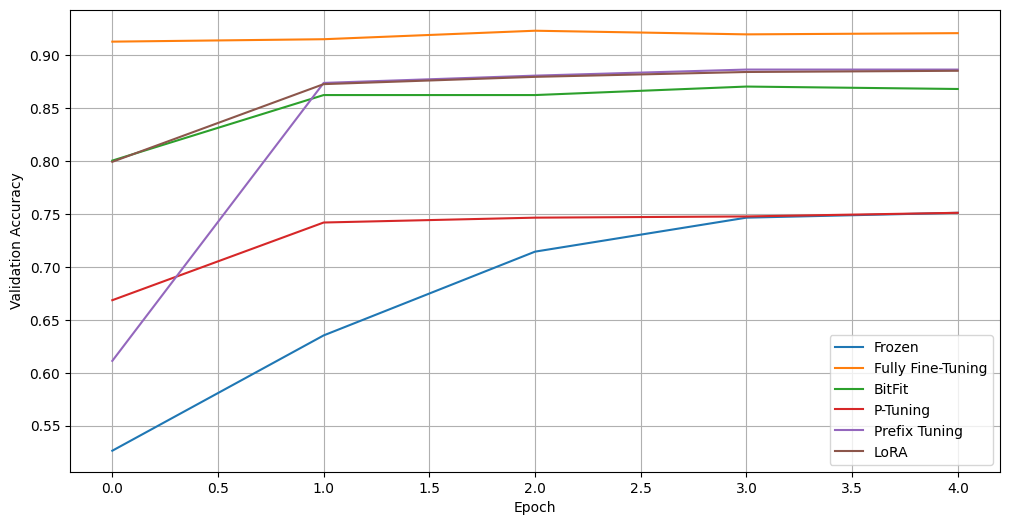

In [ ]:
plot_training_record(training_record, metric_name="val_acc")

## Adapter Tuning

Adapter Tuning（论文：Parameter-Efficient Transfer Learning for NLP），该方法设计了Adapter结构，并将其嵌入Transformer的结构里面，针对每一个Transformer层，增加了两个Adapter结构(分别是多头注意力的投影之后和第二个feed-forward层之后)，在训练时，固定住原来预训练模型的参数不变，只对新增的 Adapter 结构和 Layer Norm 层进行微调，从而保证了训练的高效性。

In [ ]:
class AdapterLayer(nn.Module):
    def __init__(self, input_size, adapter_size):
        super().__init__()
        # 第一个线性层，将输入特征从 input_size 维度降低到 adapter_size 维度
        self.down_project = nn.Linear(input_size, adapter_size)
        # ReLU 激活函数
        self.nolinearity = nn.ReLU()
        # 第二个线性层，将适配器层的特征从 adapter_size 维度恢复到原始维度
        self.up_project = nn.Linear(adapter_size, input_size)

    def forward(self, x):
        # 适配器层的前向传播
        return self.up_project(self.nolinearity(self.down_project(x)))


class BertSelfOutput(nn.Module):
    # 自注意力层的输出部分
    def __init__(self, config, adapter_size):
        super().__init__()
        # 原始的全连接层
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        # LayerNorm 层
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # Dropout 层
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # 插入的适配器层
        self.adapter = AdapterLayer(config.hidden_size, adapter_size)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        # 自注意力层的输出前向传播
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.adapter(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

class BertOutput(nn.Module):
    # 输出层
    def __init__(self, config, adapter_size):
        super().__init__()
        # 原始的全连接层
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        # LayerNorm 层
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # Dropout 层
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # 插入的适配器层
        self.adapter = AdapterLayer(config.hidden_size, adapter_size)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        # 输出层的前向传播
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.adapter(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class AdapterBert(nn.Module):
    def __init__(self, adapter_size=64):
        super().__init__()
        # 加载预训练的BERT模型
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        # 获取预训练模型的状态字典
        pretrained_state_dict = self.model.state_dict()
        # 添加一个线性分类器
        self.classifier = nn.Linear(self.model.config.hidden_size, 1)

        # 为模型的每层应用适配器
        self._apply_adapter(adapter_size=adapter_size)

        # 修改预训练状态字典，将适配器层的参数加入
        for name, param in self.model.named_parameters():
            if "adapter" in name:
                pretrained_state_dict[name] = param
        # 加载修改后的状态字典
        self.model.load_state_dict(pretrained_state_dict)

        # 冻结除适配器层以外的所有参数
        for name, param in self.model.named_parameters():
            if "adapter" not in name:
                param.requires_grad = False

        # 删除不再使用的预训练状态字典
        del pretrained_state_dict

    def _apply_adapter(self, adapter_size):
        # 为BERT模型的每层应用适配器层
        for layer in self.model.encoder.layer:
            layer.attention.output = BertSelfOutput(self.model.config, adapter_size)
            layer.output = BertOutput(self.model.config, adapter_size)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # 模型的前向传播
        outputs = self.model(input_ids, attention_mask, token_type_ids)
        # 提取[CLS]标记的表示作为特征
        feature = outputs.last_hidden_state[:, 0, :]
        # 使用分类器生成logits
        logits = self.classifier(feature)
        # 应用sigmoid激活函数得到最终的输出
        return torch.sigmoid(logits).squeeze()


# 实例化适配器BERT模型
adapter_bert = AdapterBert(adapter_size=64)
print('-'*50)
print(adapter_bert)
print('-'*50)
# 计算模型参数
count_parameters(adapter_bert)

# 训练模型
training_record["Adapter Tuning"] = train(adapter_bert, train_loader, val_loader, device, num_epochs=num_epochs, patience=patience)

--------------------------------------------------
AdapterBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 0: train_loss 0.6269, train_acc 0.6214, val_loss 0.5215, val_acc 0.7523


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 1: train_loss 0.4145, train_acc 0.8101, val_loss 0.4561, val_acc 0.7890


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 2: train_loss 0.3737, train_acc 0.8344, val_loss 0.4449, val_acc 0.8085


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 3: train_loss 0.3565, train_acc 0.8438, val_loss 0.4265, val_acc 0.8016


  0%|          | 0/2105 [00:00<?, ?it/s]

epoch 4: train_loss 0.3505, train_acc 0.8469, val_loss 0.4260, val_acc 0.8039


In [ ]:
del adapter_bert

## Plot

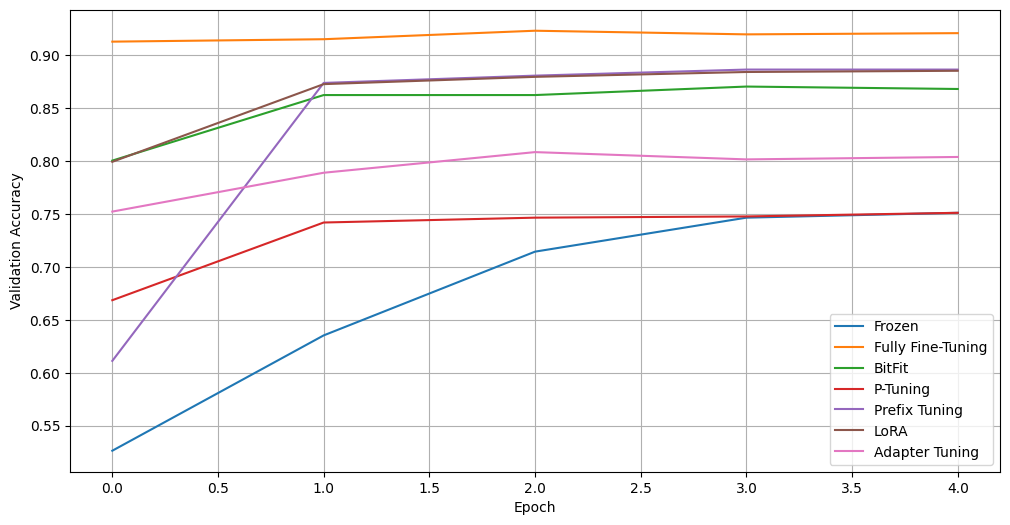

In [ ]:

plot_training_record(training_record, metric_name="val_acc")